<a href="https://colab.research.google.com/github/sofiat25/Content-Clasification-APOD/blob/main/Space_Image_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Manipulación de datos
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import textwrap

# Visualización
!pip install wordcloud matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from concurrent.futures import ThreadPoolExecutor
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO


# Preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, f1_score
from xgboost import XGBClassifier


# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Evaluación de modelos
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, roc_curve, auc

# Para evitar warnings molestos
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, display, clear_output
!pip install ipywidgets
import ipywidgets as widgets

!pip install imbalanced-learn
!pip install xgboost



# Tu API Key
api_key = "GgSnKgHqbLSlxyTzJbY4EFYooHSNffQeLYaINrhc"

# Configuración: número de días hacia atrás
dias = 365
fechas = [(datetime.today() - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(dias)]

# Lista para almacenar los datos
data = []

for fecha in fechas:
    url = f"https://api.nasa.gov/planetary/apod?api_key={api_key}&date={fecha}"
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        data.append({
            "fecha": json_data.get("date"),
            "titulo": json_data.get("title"),
            "descripcion": json_data.get("explanation"),
            "url_imagen": json_data.get("url"),
            "tipo": json_data.get("media_type")
        })
    else:
        print(f"Error con la fecha {fecha}: {response.status_code}")

# ✅ Definir la función fuera del bucle
def get_nasa_image(api_url, params):
    try:
        response = requests.get(api_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        if 'url' not in data:
            raise ValueError("La respuesta no contiene 'url'.")

        return data['url']

    except requests.exceptions.Timeout:
        print("❌ Error: La solicitud tardó demasiado (Timeout).")
    except requests.exceptions.ConnectionError:
        print("❌ Error: Problema de conexión.")
    except requests.exceptions.HTTPError as e:
        print(f"❌ Error HTTP: {e}")
    except ValueError as e:
        print(f"❌ Error en la respuesta: {e}")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")

    return None

# Creamos el DataFrame
df_apod = pd.DataFrame(data)
print(df_apod.head())


Error con la fecha 2025-08-30: 404
        fecha                                         titulo  \
0  2025-08-29                       A Dark Veil in Ophiuchus   
1  2025-08-28                      Galaxies, Stars, and Dust   
2  2025-08-27  WISPIT 2b: Exoplanet Carves Gap in Birth Disk   
3  2025-08-26                       A Leaky Solar Prominence   
4  2025-08-25                The Meteor and the Star Cluster   

                                         descripcion  \
0  The diffuse hydrogen-alpha glow of emission re...   
1  This well-composed telescopic field of view co...   
2  That yellow spot -- what is it? It's a young p...   
3  What's hovering above the Sun?  A solar promin...   
4  Sometimes even the sky surprises you.  To see ...   

                                          url_imagen   tipo  
0  https://apod.nasa.gov/apod/image/2508/DarkVeil...  image  
1  https://apod.nasa.gov/apod/image/2508/NGC7497_...  image  
2  https://apod.nasa.gov/apod/image/2508/Wispit4b...  ima

In [14]:

# 1. Crear nueva columna con el texto completo
df_apod['texto_completo'] = df_apod['titulo'] + ' ' + df_apod['descripcion']

# 2. Simplificar clases: "image" vs "no-image"
df_apod['tipo_binario'] = df_apod['tipo'].apply(lambda x: 'image' if x == 'image' else 'no-image')

# 3. Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X = tfidf_vectorizer.fit_transform(df_apod['texto_completo'])

# 4. Variable objetivo
y = df_apod['tipo_binario']

# 5. División en train/test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

print(f"Clases antes de oversampling: {Counter(y_train)}")

# 6. Oversampling con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f"Clases después de oversampling: {Counter(y_train_resampled)}")

# 7. Entrenar modelo con RandomForest
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_resampled, y_train_resampled)

# 8. Predecir probabilidades en test
y_proba = rf_model.predict_proba(X_test)

# Las clases en el mismo orden que predict_proba
print("Orden de clases en predict_proba:", rf_model.classes_)

# 9. Ajustar umbral (ejemplo: 0.3 para 'no-image')
umbral = 0.3
# Columna 1 = probabilidad de 'no-image' (depende del orden)
idx_noimage = np.where(rf_model.classes_ == "no-image")[0][0]

y_pred = np.where(y_proba[:, idx_noimage] >= umbral, "no-image", "image")

# 10. Reporte de clasificación
print(classification_report(y_test, y_pred))

# 11. Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Clases antes de oversampling: Counter({'image': 274, 'no-image': 17})
Clases después de oversampling: Counter({'image': 274, 'no-image': 274})
Orden de clases en predict_proba: ['image' 'no-image']
              precision    recall  f1-score   support

       image       0.99      0.99      0.99        69
    no-image       0.75      0.75      0.75         4

    accuracy                           0.97        73
   macro avg       0.87      0.87      0.87        73
weighted avg       0.97      0.97      0.97        73

Matriz de confusión:
[[68  1]
 [ 1  3]]


scale_pos_weight: 16.12
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        69
           1       0.60      0.75      0.67         4

    accuracy                           0.96        73
   macro avg       0.79      0.86      0.82        73
weighted avg       0.96      0.96      0.96        73

📌 Confusion Matrix:
[[67  2]
 [ 1  3]]


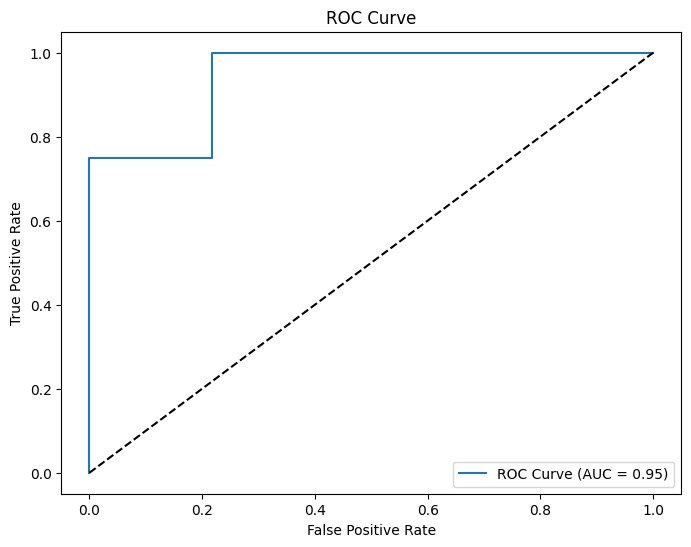

✅ Mejor threshold: 0.0138

📊 Classification Report con threshold óptimo:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        69
           1       0.21      1.00      0.35         4

    accuracy                           0.79        73
   macro avg       0.61      0.89      0.61        73
weighted avg       0.96      0.79      0.85        73

📌 Confusion Matrix con threshold óptimo:
[[54 15]
 [ 0  4]]


In [15]:
# ✅ 1. Codificar las etiquetas (y_train, y_test)
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# ✅ 2. Calcular scale_pos_weight (para balancear clases)
clases = np.bincount(y_train_enc)
neg, pos = clases[0], clases[1]
scale_pos_weight = neg / pos if pos > 0 else 1
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# ✅ 3. Entrenar el modelo XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb.fit(X_train, y_train_enc)

# ✅ 4. Predicciones y probabilidades
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# ✅ 5. Reporte y matriz de confusión
print("📊 Classification Report:")
print(classification_report(y_test_enc, y_pred))

print("📌 Confusion Matrix:")
print(confusion_matrix(y_test_enc, y_pred))

# ✅ 6. ROC Curve y AUC
fpr, tpr, thresholds = roc_curve(y_test_enc, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ✅ 7. Threshold óptimo (Youden’s J)
j_scores = tpr - fpr
idx = np.argmax(j_scores)
best_threshold = thresholds[idx]
print(f"✅ Mejor threshold: {best_threshold:.4f}")

# ✅ 8. Recalcular predicciones con el threshold óptimo
y_pred_opt = (y_proba >= best_threshold).astype(int)

print("\n📊 Classification Report con threshold óptimo:")
print(classification_report(y_test_enc, y_pred_opt))
print("📌 Confusion Matrix con threshold óptimo:")
print(confusion_matrix(y_test_enc, y_pred_opt))


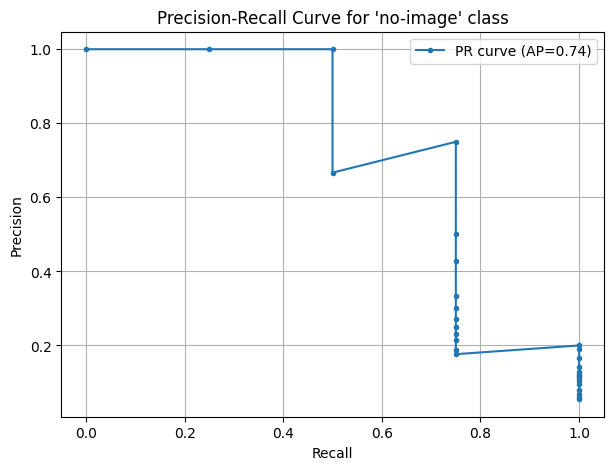

In [16]:
# Calcular probabilidades para la clase "no-image"
y_proba = rf_model.predict_proba(X_test)
idx_noimage = list(rf_model.classes_).index("no-image")
probs_noimage = y_proba[:, idx_noimage]

# Convertir etiquetas a binario: 1 = no-image, 0 = image
y_true_bin = (y_test == "no-image").astype(int)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true_bin, probs_noimage)
avg_prec = average_precision_score(y_true_bin, probs_noimage)

# Graficar
plt.figure(figsize=(7,5))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP={avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for 'no-image' class")
plt.legend()
plt.grid(True)
plt.show()

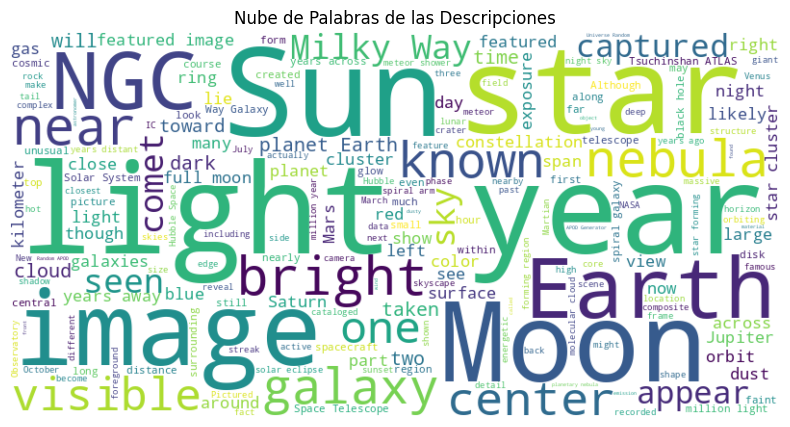

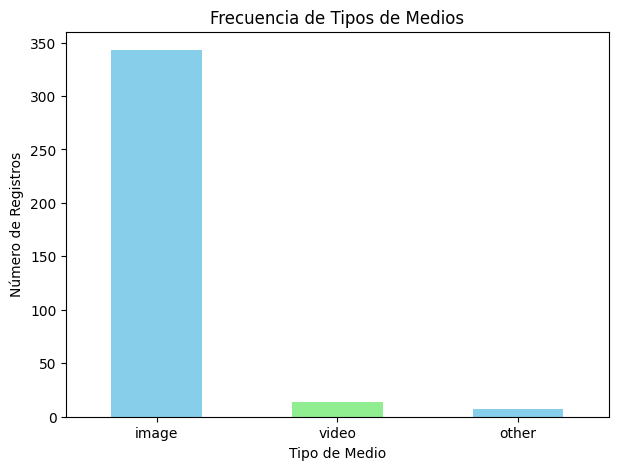

In [17]:
all_descriptions = ' '.join(df_apod['descripcion'].dropna())

if all_descriptions:
    # Crear un objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

    # Mostrar la imagen de la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras de las Descripciones')
    plt.show()
else:
    print("No hay descripciones para generar la nube de palabras.")



# --- Visualización 2: Gráfico de barras ---
# Contar la frecuencia de cada tipo de medio
media_counts = df_apod['tipo'].value_counts()

if not media_counts.empty:
    # Crear el gráfico de barras
    plt.figure(figsize=(7, 5))
    media_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
    plt.title('Frecuencia de Tipos de Medios')
    plt.xlabel('Tipo de Medio')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=0)
    plt.show()
else:
    print("No hay datos de tipos de medios para generar el gráfico de barras.")


In [18]:
def descargar_imagen(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return None

def mostrar_imagenes_grid_con_titulo(urls, titulos, max_columnas=4, img_width=25):
    total = len(urls)
    columnas = min(max_columnas, total)
    filas = (total + columnas - 1) // columnas

    # Descarga imágenes en paralelo
    with ThreadPoolExecutor() as executor:
        imagenes = list(executor.map(descargar_imagen, urls))

    fig, axes = plt.subplots(filas, columnas, figsize=(columnas * 4.5, filas * 4))
    axes = axes.flatten()

    for i, (img, titulo) in enumerate(zip(imagenes, titulos)):
        if img:
            axes[i].imshow(img)
            axes[i].axis('off')

            # Ajustar títulos largos
            titulo_envuelto = "\n".join(textwrap.wrap(titulo, width=img_width))
            axes[i].set_title(titulo_envuelto, fontsize=9, pad=8)
        else:
            axes[i].text(0.5, 0.5, 'Error', ha='center', va='center', fontsize=12)
            axes[i].axis('off')

    # Ocultar ejes sobrantes
    for j in range(i + 1, filas * columnas):
        axes[j].axis('off')

    plt.subplots_adjust(hspace=0.8)
    plt.show()

    # Scroll en caso de muchas imágenes
    out = widgets.Output()
    with out:
        plt.show()
    display(widgets.Box([out], layout=widgets.Layout(overflow='scroll', height='600px')))

In [19]:
# Dropdown con las fechas
dropdown = widgets.Dropdown(
    options=df_apod['fecha'].tolist(),
    description='Fecha:'
)

# Caja para mostrar imagen y descripción
output = widgets.Output()

def mostrar_imagen(change):
    with output:
        clear_output()
        fecha = change['new']
        fila = df_apod[df_apod['fecha'] == fecha].iloc[0]
        print(f"Título: {fila['titulo']}")
        print(f"Descripción: {fila['descripcion']}")
        display(Image(url=fila['url_imagen']))

dropdown.observe(mostrar_imagen, names='value')
display(dropdown, output)


Dropdown(description='Fecha:', options=('2025-08-29', '2025-08-28', '2025-08-27', '2025-08-26', '2025-08-25', …

Output()

In [20]:
# Dropdown de tipo de media
tipo_options = ['image', 'video']  # si hay otros tipos, agrega aquí
tipo_dropdown = widgets.Dropdown(
    options=['Todos'] + tipo_options,
    description='Tipo de media:'
)

# Caja de texto para palabra clave
palabra_text = widgets.Text(
    description='Buscar palabra:',
    placeholder='Escribe una palabra...'
)

# Dropdown de fechas (se actualizará según filtros)
fecha_dropdown = widgets.Dropdown(
    options=df_apod['fecha'].tolist(),
    description='Fecha:'
)

output = widgets.Output()

# Función para actualizar fechas según filtros
def actualizar_fechas(*args):
    df_filtrado = df_apod.copy()

    # Filtrar por tipo de media
    if tipo_dropdown.value != 'Todos':
        df_filtrado = df_filtrado[df_filtrado['tipo'] == tipo_dropdown.value]

    # Filtrar por palabra clave
    if palabra_text.value.strip() != '':
        df_filtrado = df_filtrado[
            df_filtrado['titulo'].str.contains(palabra_text.value, case=False) |
            df_filtrado['descripcion'].str.contains(palabra_text.value, case=False)
        ]

    # Actualizar fechas
    fecha_dropdown.options = df_filtrado['fecha'].tolist()
    mostrar_imagen({'new': fecha_dropdown.value})  # mostrar la primera imagen filtrada

# Función para mostrar la imagen seleccionada
def mostrar_imagen(change):
    with output:
        clear_output()
        if fecha_dropdown.value is None:
            print("No hay resultados con esos filtros.")
            return
        fila = df_apod[df_apod['fecha'] == fecha_dropdown.value].iloc[0]
        print(f"Título: {fila['titulo']}")
        print(f"Descripción: {fila['descripcion']}")
        display(Image(url=fila['url_imagen']))

# Conectar widgets a funciones
tipo_dropdown.observe(actualizar_fechas, names='value')
palabra_text.observe(actualizar_fechas, names='value')
fecha_dropdown.observe(mostrar_imagen, names='value')

# Mostrar widgets y salida
display(tipo_dropdown, palabra_text, fecha_dropdown, output)

# Mostrar la primera imagen al inicio
actualizar_fechas()
def actualizar_fechas(*args):
    df_filtrado = df_apod.copy()

    # Filtrar por tipo de media
    if tipo_dropdown.value != 'Todos':
        df_filtrado = df_filtrado[df_filtrado['tipo'] == tipo_dropdown.value]

    # Filtrar por palabra clave
    if palabra_text.value.strip() != '':
        df_filtrado = df_filtrado[
            df_filtrado['titulo'].str.contains(palabra_text.value, case=False) |
            df_filtrado['descripcion'].str.contains(palabra_text.value, case=False)
        ]

    # Actualizar fechas
    fecha_dropdown.options = df_filtrado['fecha'].tolist()

    # Mostrar la primera imagen filtrada
    mostrar_imagen({'new': fecha_dropdown.value})

    # ✅ Mostrar nube de palabras filtrada
    generar_nube(df_filtrado, columna='descripcion')


Dropdown(description='Tipo de media:', options=('Todos', 'image', 'video'), value='Todos')

Text(value='', description='Buscar palabra:', placeholder='Escribe una palabra...')

Dropdown(description='Fecha:', options=('2025-08-29', '2025-08-28', '2025-08-27', '2025-08-26', '2025-08-25', …

Output()

In [21]:
# Función para generar nube de palabras
def generar_nube(df_filtrado, columna='descripcion'):
    # Unir todo el texto de la columna
    texto = " ".join(df_filtrado[columna].dropna().tolist())

    # Crear nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(texto)

    # Mostrar nube
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

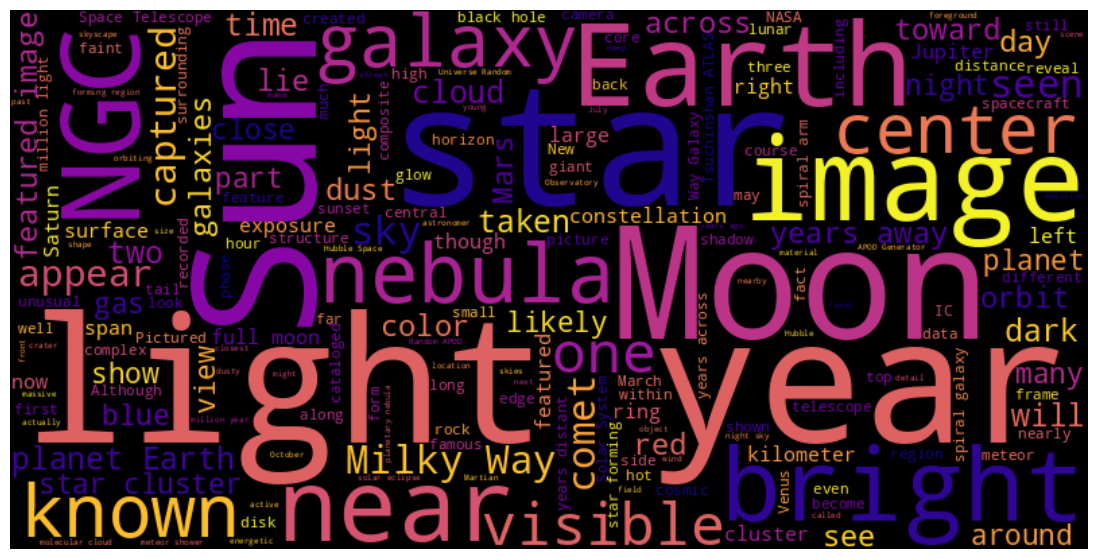

In [22]:
generar_nube(df_apod, columna='descripcion')


In [23]:
print(df_apod['tipo'].value_counts())


tipo
image    343
video     14
other      7
Name: count, dtype: int64


In [24]:
df_apod['texto_completo'] = df_apod['titulo'] + ' ' + df_apod['descripcion']

# Crear un vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# Conviertir el texto a una matriz TF-IDF
X = tfidf_vectorizer.fit_transform(df_apod['texto_completo'])

# Definir la variable objetivo (las categorías)
y = df_apod['tipo']